In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import json

### 1) Utilization Rates per Station

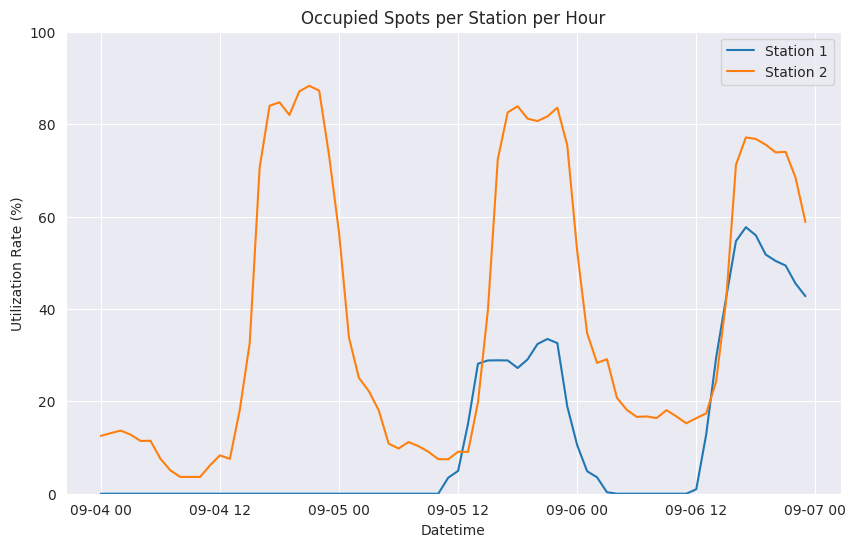

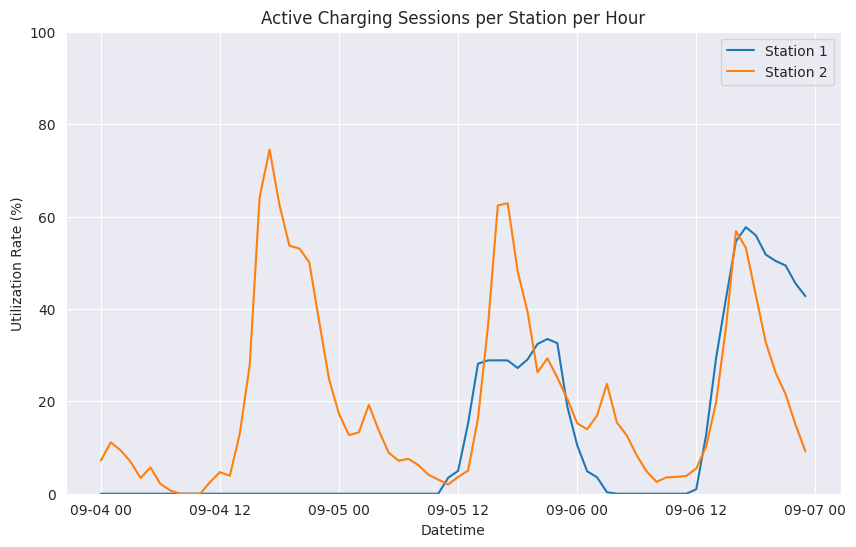

In [37]:
# Get number of stations per site
df_charging = pd.read_pickle("data/charging_modified.pkl")
stations_per_site = df_charging.groupby('siteID')['stationID'].nunique()

# Time Interval
start_date = "2018-09-04"
end_date = "2018-09-06"

start_date_time = pd.to_datetime(start_date)
end_date_time = pd.to_datetime(end_date) + pd.Timedelta('1 day') - pd.Timedelta('1 second')

# Generate df with each row representing a minute in the time interval
df_time_interval = pd.date_range(start=start_date_time, end=end_date_time, freq='T')
df_time_interval = pd.DataFrame(df_time_interval, columns=['datetime'])
df_time_interval['datetime'] = pd.to_datetime(df_time_interval['datetime'], utc=True)

# Resample connectionTime and disconnectTime to full minutes, e.g., 10:31:20 -> 10:31:00
df_charging['connectionTime'] = df_charging['connectionTime'].dt.floor('T')
df_charging['disconnectTime'] = df_charging['disconnectTime'].dt.floor('T')

def count_sessions_total_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp):
    filtered_df = data[(data['connectionTime'] <= point_in_time) & (data['disconnectTime'] >= point_in_time )]
    return filtered_df.shape[0]

def count_sessions_active_charging_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp):
    filtered_df = data[(data['connectionTime'] <= point_in_time) & (data['disconnectTime'] >= point_in_time) & ((data['doneChargingTime'].isna()) | (data['doneChargingTime'] >= point_in_time))]
    return filtered_df.shape[0]

for site_id, data in df_charging.groupby('siteID'):
    df_time_interval[f'site{site_id}_total_count'] = df_time_interval['datetime'].apply(lambda datetime: count_sessions_total_at_point_in_time(data, datetime))
    df_time_interval[f'site{site_id}_charging_count'] = df_time_interval['datetime'].apply(lambda datetime: count_sessions_active_charging_at_point_in_time(data, datetime))

# Calculate the utilization rate for each station in minute
for site_id in stations_per_site.index:
    df_time_interval[f'site{site_id}_utilizationRate'] = (df_time_interval[f'site{site_id}_total_count'] / stations_per_site[site_id]) * 100
    df_time_interval[f'site{site_id}_utilizationRate_charging'] = (df_time_interval[f'site{site_id}_charging_count'] / stations_per_site[site_id]) * 100

df_time_interval = df_time_interval.set_index('datetime')
df_time_interval = df_time_interval.resample('H').mean()

def plot(df, title, y_column):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Datetime')
    plt.ylabel('Utilization Rate (%)')
    plt.ylim(0, 100)
    plt.grid(True)
    
    # Iterate over each station
    for site_id in stations_per_site.index:
        plt.plot(df.index, df[f'site{site_id}_{y_column}'], label=f'Station {site_id}')
    plt.legend()
    plt.show()

plot(df_time_interval, 'Occupied Spots per Station per Hour', 'utilizationRate')
plot(df_time_interval, 'Active Charging Sessions per Station per Hour', 'utilizationRate_charging')


# kWh Delivered per Station per Hour

,site1_total_count,site1_charging_count,site2_total_count,site2_charging_count,site1_utilizationRate,site1_utilizationRate_charging,site2_utilizationRate,site2_utilizationRate_charging
datetime,,,,,,,,
2018-09-04 00:00:00+00:00,0.0,0.0,6.883333,3.950000,0.0,0.0,12.515152,7.181818
2018-09-04 01:00:00+00:00,0.0,0.0,7.216667,6.116667,0.0,0.0,13.121212,11.121212
2018-09-04 02:00:00+00:00,0.0,0.0,7.516667,5.150000,0.0,0.0,13.666667,9.363636
2018-09-04 03:00:00+00:00,0.0,0.0,7.033333,3.800000,0.0,0.0,12.787879,6.909091
2018-09-04 04:00:00+00:00,0.0,0.0,6.283333,1.866667,0.0,0.0,11.424242,3.393939
